# SCRIPT 2
Edit raw data and compute velocity components.

Steps:
1. ds_raw: Load an individual raw drifter dataset with GPS, temperature and other variables on non-uniform t.
    Create tgrid_hourly from the original time data.
2. ds_qc: Flag + remove bad GPS data
    - Where the GPS has dropped out (= mode),
    - Where it is outside the North Atlantic box (na_lonlim, na_latlim)
    - Where the velocity is unrealistic (larger than 3 m/s)
    - Where the time series of longitude and latitude (compared to a one-dimensional five-point median filter) is more than five standard deviations from the five-point median)
     Compute the u and v velocities on the QC GPS fixes
4. ds_lowess: Smooth the GPS (and velocities) using the Lowess filter*.  *Shane's code online doesn't seem to smooth velo with a Lowess
5. ds_hourly: Hourly interpolate the resultant ds_lowess back onto the tgrid_hourly.  Interpolate the other parameters from ds_raw onto the hourly grid (temperature, etc)
    > 'linear' for continuous variables
    > 'nearest neighbour' for discrete ones

6. save as netcdf file

Last modified: 5 Sep 2021

In [1]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Import modules

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import datetime
import gsw
import os
import glob
import sys
import re
from scipy import stats





In [2]:
%load_ext autoreload
%autoreload 2

# Local import
# > Make sure SIO_wrap dir is on the same path as this script.

from SIO_wrap import dir_tree, fnames
from SIO_wrap.lowess import LatLonLocalWess
from SIO_wrap import jlab_python as jlab
from SIO_wrap import drifter_qc as dqc

from setdir import *

/Users/eddifying/Python/drifters/ already exists
/Users/eddifying/Python/drifters/02-code/ already exists
/Users/eddifying/Python/drifters/02-code/SIO_wrap/ already exists
/Users/eddifying/Python/drifters/01-data/04-aux/ already exists
/Users/eddifying/Python/drifters/01-data/02-intermediate/ already exists


In [3]:
##################---------   LOCAL FUNCTIONS    ---------##################

def latlon_extremes(var, igood):
    """
    var   : xarray dataset that containg the 'flag' and lat/lon variables.
    igood : int or float; value of the good flag

    Prints the min/max of lat and lon.

    <!> This function breaks if the lat/lon variable names change.
    """
    # Select lat/lon where flag is good
    bool_cond = var.flag.values==igood

    print('lat min: ', var.GPS_Latitude_deg.values[bool_cond].min())
    print('lat max: ', var.GPS_Latitude_deg.values[bool_cond].max())
    print('lon min: ', var.GPS_Longitude_deg.values[bool_cond].min())
    print('lon max: ', var.GPS_Longitude_deg.values[bool_cond].max())
    

def tgrid_hourly(time_da):

    # Compute the hourly time grid
    # Create the regular time grid
    time_as_series = time_da.to_series()
    dt = time_as_series.diff().mean()

    # Sampled time in datetime format
    time = pd.to_datetime(time_da.values)

    # Round up the time to the nearest hour
    time_rounded = time.round('60min')
    # > start time
    time_start = time_rounded[0]
    # > for end time check the rounded value is not higher than sampled one
    if time_rounded[-1] == time[-1]:
        time_end = time_rounded[-1]
    else:
        time_end = time_rounded[-2]

    # Hourly time grid
    tgrid = pd.date_range(time_start, time_end, freq='1H')
    tgrid_sec = (tgrid - ref_time).total_seconds()

    return tgrid, tgrid_sec

# User edits

In [90]:
# Path for the output data
data_dir = dir_tree.dir_out

#--------------
# Flag value - good=1, bad=4
bad_gps_flagval = 4 
good_flagval = 1

# FLAG 1: Latitude values less than this threshold are flagged + removed?
latbad_threshold = 0

# FLAG 2: North Atlantic box; values outside this box are flagged + removed?
# Defined from -180 to 180 (lon) and -90 to 90 (lat)
na_lonlim = [-80, 30]
na_latlim = [40, 80]

#--------------
# Speed threshold; values outside [-3, 3] m/s are flagged + removed?
vel_threshold = 3 # in m/s

#--------------
# LOWESS params
poly_order = 1
bandwidth = 2

#------------
# Names of variables
latname = 'GPS_Latitude_deg'
lonname = 'GPS_Longitude_deg'
uvelname = 'uvel'
vvelname = 'vvel'

#--------------
# Time formats
tstamp_strftime = '%Y%m%d'  # Filename timestamp
timcol_strftime = '%Y-%m-%d %H:%M:%S'  # Convert text to datetime format 

# Reference date for computing time in seconds
# Can use an earlier time reference if data start before 2000
ref_time = datetime.datetime(2000, 1, 1)

#--------------
# List of variable names split between float/int types based on whether the 
# variables are continuous or discrete, respectively.
# <!> If the names of variables change, update the lists by printing a list of 
# all the names from the raw datafile: list(xarrayDataset.keys())

integ_vars = ['Drogue_cnts', 'GPS_HDOP', 'GPS_FixDelay', 'GPS_TTFF', 
              'GPS_NumSat', 'SBD_Transmit_Delay', 'SBD_Retries']

float_vars = [lonname, latname, 'SST_degC',
              'SLP_mB', 'Battery_volts', uvelname, vvelname]


# Step 1. Load raw data

Check the list of PIDs and decide which ones need to be updated.

In [5]:
# Check the list of Platform IDs for TERIFIC
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)


In [6]:
# Check whether a given Platform ID has been processed and is up-to-date
# If not, then add it to the update list
PID_to_update = []
counter = 0


# Extract a list with the names of existing raw data files.
i = 2
pid1 = (PID["PID"].values)[i].astype('str')
PID1 = (PID["PID"].values)[i]

# Extract a list with the names of existing raw data files.
fname = 'pid'+str(PID1)+'_*'
existing_files = glob.glob(cat_interim_path(fname))

# Check whether any files exist in the intermediate directory for that PID
if len(existing_files) > 0:

    # Extract the end date from the filename
    existing_files = sorted(existing_files)
    # Needs existing_files to be sorted() so the last one is latest
    end_date = (existing_files[-1])[-11:-3] 
    t1 = datetime.datetime.strptime(end_date, '%Y%m%d')  

    # Check what the latest raw file was
    raw_files = glob.glob(cat_raw_path(fname))
    if not len(raw_files) > 0:
        print('No raw file for that PID!')
    
    # Check the end date
    raw_files = sorted(raw_files)
    end_date_raw = (raw_files[-1])[-11:-3]
    t_raw = datetime.datetime.strptime(end_date_raw, '%Y%m%d')

    if t1==t_raw:
        print('Up to date processed file exists')
        
    else:
        counter += 1
        PID_to_update.append(PID1)
        print(str(counter)+'. pid('+pid1+') - Ended:'+end_date
              +', New end:'+t_raw)
        
else:
    counter += 1
    print(str(counter)+'. pid('+pid1
          +') - No previous raw data files.\n')
    PID_to_update.append(PID1)



1. pid(300234068243460) - No previous raw data files.



In [7]:
# Load a raw file to process it
i = 0
pid1 = (PID["PID"].values)[i].astype('str')
PID1 = (PID["PID"].values)[i]

# Set the filename convention
fname = 'pid'+str(PID1)+'_*'
raw_files = glob.glob(cat_raw_path(fname))
raw_files = sorted(raw_files)
# Find the most recent file (alphabetically, rather than by time)
raw_files = raw_files[-1]

#--------------------------------------
# Open the dataset
ds_raw = xr.open_dataset(raw_files)
#--------------------------------------
# Total number of points 
total_points = int(ds_raw.time.size)

# Compute a time vector in seconds
dtime_sec = (pd.to_datetime(ds_raw.time.values) - ref_time).total_seconds()
ds_raw['time_seconds'] = ("time", dtime_sec)

# Create the hourly time grid
tgrid_hourly, tgrid_sec = tgrid_hourly(ds_raw.time)

# Find the modes for lat and lon
mode1 = stats.mode(ds_raw[latname])
lat_mode = mode1.mode
mode_count = mode1.count

mode1 = stats.mode(ds_raw[lonname])
lon_mode = mode1.mode

## Step 2. Create ds_qc the quality-controlled GPS fixes

 
ds_qc: Flag + remove bad GPS data
- Where the GPS has dropped out (= mode),
- Where it is outside the North Atlantic box (na_lonlim, na_latlim)
- Where the velocity is unrealistic (larger than 3 m/s)
- Where the time series of longitude and latitude (compared to a one-dimensional five-point median filter) is more than five standard deviations from the five-point median)

Compute the u and v velocities on the QC GPS fixes

In [43]:
# Add a field FLAG with the same time coordinate.
# Start by labelling all data 'good' (flag=igood)
ds_qc = ds_raw

# Remove variables we won't use here
fields_to_remove = ['Battery_volts', 'GPS_HDOP', 'GPS_FixDelay', 'GPS_TTFF',
                    'GPS_NumSat', 'SBD_Transmit_Delay', 'SBD_Retries',
                   'SST_degC', 'SLP_mB']

ds_qc = ds_qc.drop(fields_to_remove, errors='ignore')

ds_qc["flag"] = ('time', good_flagval * np.ones(ds_qc.time.shape, 
                                                 dtype=np.int8))


# Where the GPS has dropped out (= mode),
# Based on previous investigations, there are a lot of -90 values for 
# GPS_Latitude_deg.  
if mode_count > 100:
    # Kind of arbitrary but only do this if there are a lot of mode value
    ds_qc = dqc.flag_gps_dropout(ds_qc, latname, 
                              lat_mode, bad_gps_flagval)

    ds_qc = dqc.flag_gps_dropout(ds_qc, lonname, 
                              lon_mode, bad_gps_flagval)

latlon_extremes(ds_qc, good_flagval)

# Print update on flagged data
print("\n> > Flags - stage 1 < <\n")
num_flags1 = dqc.num_ibad(ds_qc, bad_gps_flagval)
num_percent1 = num_flags1 / total_points
percentage = "{:.1%}".format(num_percent1)
print("Flagged data as percentage: %s\n" % percentage)


# Based on the region
ds_qc = dqc.flag_gps_region(ds_qc, latname,
                          na_latlim, bad_gps_flagval)
ds_qc = dqc.flag_gps_region(ds_qc, lonname,
                         na_lonlim, bad_gps_flagval)

latlon_extremes(ds_qc, good_flagval)
    

# Print update on flagged data
print("\n> > Flags - stage 1 + 2 < <\n")
num_flags2 = dqc.num_ibad(ds_qc, bad_gps_flagval)
num_percent2 = num_flags2 / total_points
percentage = "{:.1%}".format(num_percent2)
print("Total flagged data as percentage: %s\n" % percentage)

num_flags2_diff = num_flags2 - num_flags1
print("Flagged data at this step only: %s\n" % str(num_flags2_diff))


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Remove flagged data, otherwise it might affect the lowess filtering

print("Removing flagged data. \n")
ds_qc = ds_qc.where(ds_qc.flag==good_flagval, drop=True) # this is too slow

lat min:  59.961
lat max:  63.505
lon min:  -60.7
lon max:  -47.369

> > Flags - stage 1 < <

Total # of points: 4435
Total # of flagged points: 219
Flagged data as percentage: 4.9%

lat min:  59.961
lat max:  63.505
lon min:  -60.7
lon max:  -47.369

> > Flags - stage 1 + 2 < <

Total # of points: 4435
Total # of flagged points: 219
Total flagged data as percentage: 4.9%

Flagged data at this step only: 0

Removing flagged data. 



**Flagging GPS dropouts (-90 or -180):**

**Flagging GPS out-of-bounds:**

**Flag based on velocity > vel_threshold (default: 3 m/s)**

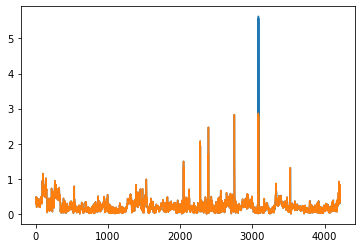

In [44]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# velocity calculation
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
GPSlat = ds_qc[latname].to_numpy()
GPSlon = ds_qc[lonname].to_numpy()
u_orig, v_orig = jlab.latlon2uv(ds_qc['time_seconds'], GPSlat, GPSlon)
velmag = np.sqrt(np.square(u_orig) + np.square(v_orig))

# Plot to verify
plt.plot(velmag)    

ds_qc[uvelname] = ('time', u_orig)
ds_qc[vvelname] = ('time', v_orig)

# Flag the bad stuff
ds_qc.flag.values[velmag > vel_threshold] = bad_gps_flagval

# Need to count how many were removed here

# Removing flagged data
ds_qc = ds_qc.where(ds_qc.flag==good_flagval, drop=True) # this is too slow

if 1:
    GPSlat = ds_qc[latname].to_numpy()
    GPSlon = ds_qc[lonname].to_numpy()

    u_orig, v_orig = jlab.latlon2uv(ds_qc['time_seconds'], GPSlat, GPSlon)
    velmag = np.sqrt(np.square(u_orig) + np.square(v_orig))
    plt.plot(velmag)
    



### What about the five-point median filter?


(3000.0, 3200.0)

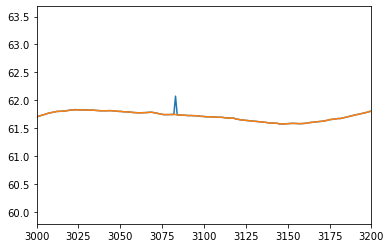

In [45]:
# Five-point median filter
medval = ds_qc.rolling(time=5, center=True).median()
stdval = ds_qc.rolling(time=5, center=True).std()


plt.plot(GPSlat)
plt.plot(medval[latname])

plt.xlim([3000, 3200])

(3000.0, 3200.0)

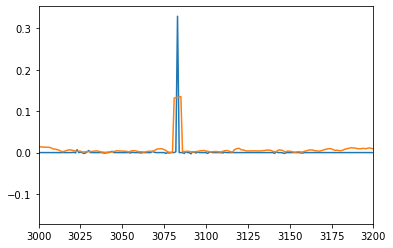

In [46]:
plt.plot(GPSlat-medval[latname])
plt.plot(stdval[latname])
plt.xlim([3000, 3200])

## Step 3. Run Lowess filter

In [48]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Create entries for lowess lat/lon
time = ds_qc.time.values
ds_lowess = xr.Dataset(coords=dict(time=(["time"], time)))
ds_lowess = ds_lowess.assign_attrs(ds_qc.attrs)

ds_lowess[latname] = ('time', np.ones(len(ds_qc.time)))
ds_lowess[lonname] = ('time', np.ones(len(ds_qc.time)))


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# LOWESS: Locally Weighted Scatterplot Smoother (Elipot et al 2016)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
time_sec = ds_qc['time_seconds'].values
lon = ds_qc[lonname].values
lat = ds_qc[latname].values
llat, llon = LatLonLocalWess(time_sec, lon, lat, poly_order, bandwidth)

ds_lowess[latname] = ('time', llat)
ds_lowess[lonname] = ('time', llon)

# Cannot use the same code to Lowess filter the velocities since it treats latitude and longitude differently.
ds_lowess


<xarray.Dataset>
Dimensions:            (time: 4214)
Coordinates:
  * time               (time) datetime64[ns] 2019-12-04T22:40:00 ... 2020-06-...
Data variables:
    GPS_Latitude_deg   (time) float64 59.96 59.96 59.97 ... 61.25 61.2 61.06
    GPS_Longitude_deg  (time) float64 -47.37 -47.37 -47.39 ... -60.55 -60.7
Attributes:
    Platform_ID:   300234066519040
    End Time:      2020-06-09T15:00:00
    Project:       TERIFIC
    Originator:    EFW
    Institution:   National Oceanography Centre, UK
    Date created:  2022-01-08

## Step 4. Interpolate hourly

Revised from Oana's method (using arrays) to use dataset in xarray.


In [84]:
# Empty lists for storing the hourly data and new column names
hourly_arr = []
arr_names = []


# Create the new hourly xarray dataset
ds_hourly = xr.Dataset(coords=dict(time=(["time"], tgrid_hourly)))
ds_hourly = ds_hourly.assign_attrs(ds_lowess.attrs)
ds_hourly
time_sec = ds_qc.time_seconds
time_sec_raw = ds_raw.time_seconds

# Get the variable names
varnames_list = list(ds_raw.keys())
varnames_qc_list = list(ds_qc.keys())
varnames_lowess_list = list(ds_lowess.keys())

# Create temporary array to store hourly interp data
c_len = len(tgrid_hourly)
arr = np.ones((c_len,))

# Iterate through the variable names and set the interpolation method 
# based on the dtype of the data
k = 0
for varname in set(varnames_list + varnames_qc_list):
    if (varname in varnames_lowess_list):
        # Lowess filtered variables (GPS lat and lon)
        if varname in integ_vars:
            interp_method = 'nearest'
        elif varname in float_vars:
            interp_method = 'linear'

        var = ds_lowess[varname].values
        fc_interp = interp1d(time_sec, var, interp_method,
                             fill_value='extrapolate')
        arr = fc_interp(tgrid_sec)

        ds_hourly[varname] = ('time', arr)
        print('Using lowess for '+varname)
        
    elif (varname in varnames_qc_list):
        # QC drifter variables (velocity)
        if varname in integ_vars:
            interp_method = 'nearest'
        elif varname in float_vars:
            interp_method = 'linear'

        var = ds_qc[varname].values
        fc_interp = interp1d(time_sec, var, interp_method,
                             fill_value='extrapolate')
        arr = fc_interp(tgrid_sec)

        ds_hourly[varname] = ('time', arr)
        print('Using qc for '+varname)


    elif (varname in integ_vars) or (varname in float_vars):
        # Raw drifter variables
        if varname in integ_vars:
            interp_method = 'nearest'
        elif varname in float_vars:
            interp_method = 'linear'

        var = ds_raw[varname].values
        fc_interp = interp1d(time_sec_raw, var, interp_method,
                             fill_value='extrapolate')
        arr = fc_interp(tgrid_sec)

        ds_hourly[varname] = ('time', arr)
    else:
        print("Variables not interpolated hourly: < %s >\n" % varname)
        
ds_hourly

Using qc for vvel
Using qc for Drogue_cnts
Using qc for flag
Using qc for uvel
Using lowess for GPS_Latitude_deg
Using lowess for GPS_Longitude_deg
Using qc for time_seconds


<xarray.Dataset>
Dimensions:             (time: 4505)
Coordinates:
  * time                (time) datetime64[ns] 2019-12-04T23:00:00 ... 2020-06...
Data variables: (12/16)
    GPS_NumSat          (time) float64 4.0 4.0 15.0 15.0 ... 5.0 7.0 7.0 7.0
    GPS_HDOP            (time) float64 5.0 4.0 12.0 12.0 ... 6.0 2.0 2.0 2.0
    Battery_volts       (time) float64 11.8 11.6 11.6 11.6 ... 5.867 5.833 5.8
    vvel                (time) float64 0.1081 0.1387 0.1391 ... -0.6953 -0.7417
    SBD_Retries         (time) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    Drogue_cnts         (time) float64 40.0 40.0 40.0 40.0 ... 50.0 50.0 50.0
    ...                  ...
    uvel                (time) float64 -0.2938 -0.3419 ... -0.3407 -0.3769
    SBD_Transmit_Delay  (time) float64 10.0 10.0 10.0 50.0 ... 290.0 290.0 290.0
    GPS_Latitude_deg    (time) float64 59.96 59.97 59.97 ... 61.11 61.08 61.06
    SLP_mB              (time) float64 850.0 850.0 850.0 ... 850.0 850.0 850.0
    GPS_Longitude_deg   (time) float64 -47.37 -47.39 -47.42 ... -60.67 -60.7
    time_seconds        (time) float64 6.288e+08 6.288e+08 ... 6.45e+08 6.45e+08
Attributes:
    Platform_ID:   300234066519040
    End Time:      2020-06-09T15:00:00
    Project:       TERIFIC
    Originator:    EFW
    Institution:   National Oceanography Centre, UK
    Date created:  2022-01-08

(59.6, 62.0)

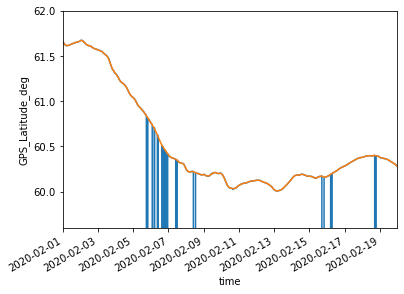

In [86]:
ds_raw[latname].plot()
ds_hourly[latname].plot()

plt.xlim(['2020-02-01T', '2020-02-20T'])
plt.ylim([59.6, 62])

(30.0, 62.0)

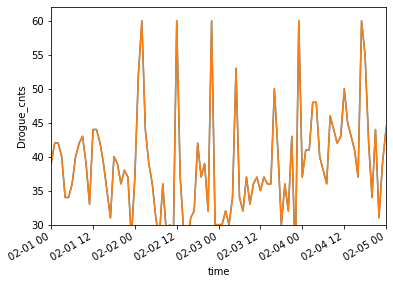

In [87]:
varname = 'Drogue_cnts'
ds_raw[varname].plot()
ds_hourly[varname].plot()
plt.xlim(['2020-02-01T', '2020-02-05T'])
plt.ylim([30, 62])

(18293.0, 18297.0)

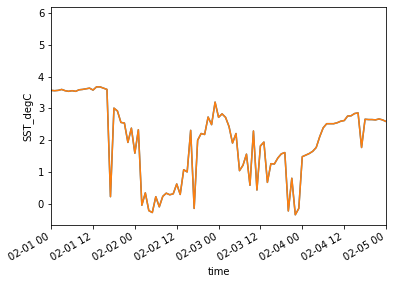

In [88]:
varname = 'SST_degC'
ds_raw[varname].plot()
ds_hourly[varname].plot()
plt.xlim(['2020-02-01T', '2020-02-05T'])
#plt.ylim([30, 62])


In [91]:
# attributes for Dataset
#ds_hourly.time_seconds.attrs["units"] = "seconds since %s" % str(ref_time.strftime(timcol_strftime))
ds_hourly[lonname].attrs["long_name"] = "longitude_lowess"
ds_hourly[latname].attrs["long_name"] = "latitude_lowess"
ds_hourly[uvelname].attrs["units"] = "m/s"
ds_hourly[vvelname].attrs["units"] = "m/s"
ds_hourly[uvelname].attrs["long_name"] = "zonal_velocity"
ds_hourly[vvelname].attrs["long_name"] = "meridional_velocity"




In [ ]:

# 4.2 Add row of ones for velocity flags
flag_vel = np.ones(len(tgrid))
flag_vel[abs(u) > threshold_ms] = ibad 
flag_vel[abs(v) > threshold_ms] = ibad 




In [95]:
# Update attributes
dstr = datetime.datetime.today()
dstr = dstr.replace(hour=0, minute=0, second=0, 
                    microsecond=0).strftime('%Y-%m-%d')

maxtime = tgrid_hourly.max()
maxtimestr = pd.to_datetime(maxtime).strftime('%Y-%m-%dT%H:%M:%S')

procstr = f'Flagged GPS out of LabSea, ran Lowess filter with poly_order({poly_order}) and bandwidth({bandwidth})'

# Create a dictionary of attributes
attr_dict = {"Platform_ID": PID1,
             "End Time": maxtimestr,
             "Date created": dstr,
             "Processing": procstr,
            }


ds_hourly = ds_hourly.assign_attrs(attr_dict)

# Output filename (will be the same as raw, but in 02-intermediate/)
data_fname = raw_files[-30:-3]+'.nc'
data_fpath = cat_interim_path(data_fname)

ds_hourly.to_netcdf(data_fpath)

ds_hourly

<xarray.Dataset>
Dimensions:             (time: 4505)
Coordinates:
  * time                (time) datetime64[ns] 2019-12-04T23:00:00 ... 2020-06...
Data variables: (12/16)
    GPS_NumSat          (time) float64 4.0 4.0 15.0 15.0 ... 5.0 7.0 7.0 7.0
    GPS_HDOP            (time) float64 5.0 4.0 12.0 12.0 ... 6.0 2.0 2.0 2.0
    Battery_volts       (time) float64 11.8 11.6 11.6 11.6 ... 5.867 5.833 5.8
    vvel                (time) float64 0.1081 0.1387 0.1391 ... -0.6953 -0.7417
    SBD_Retries         (time) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    Drogue_cnts         (time) float64 40.0 40.0 40.0 40.0 ... 50.0 50.0 50.0
    ...                  ...
    uvel                (time) float64 -0.2938 -0.3419 ... -0.3407 -0.3769
    SBD_Transmit_Delay  (time) float64 10.0 10.0 10.0 50.0 ... 290.0 290.0 290.0
    GPS_Latitude_deg    (time) float64 59.96 59.97 59.97 ... 61.11 61.08 61.06
    SLP_mB              (time) float64 850.0 850.0 850.0 ... 850.0 850.0 850.0
    GPS_Longitude_deg   (time) float64 -47.37 -47.39 -47.42 ... -60.67 -60.7
    time_seconds        (time) float64 6.288e+08 6.288e+08 ... 6.45e+08 6.45e+08
Attributes:
    Platform_ID:   300234066519040
    End Time:      2020-06-09T15:00:00
    Project:       TERIFIC
    Originator:    EFW
    Institution:   National Oceanography Centre, UK
    Date created:  2022-01-12
    Processing:    Flagged GPS out of LabSea, ran Lowess filter with poly_ord...

In [ ]:


# ~ ~ print update ~ ~ 
if len(existing_files) > 0:
    print("Existing raw data files: \n%s\n" % existing_files)
else:
    sys.exit("No previous raw data files.\n")

# ~ ~ filenaming convention ~ ~
# If there are multiple files with raw data (i.e. non-updated datasets), select 
# the latest one updated.
# The file names are distinguished by the timestamp appended to the filename 
# and has <tstamp_strftime> format (see 'user edits' section).
# The data are cropped such that the last day is fully sampled (spans 0h-23h).
# The timestamp in the filename is the latest downloaded fully sampled day.

# Extract the timestamp part of the filename(s) in a list
tstamp = [date for file in existing_files 
            for date in re.findall("(\d{8})", file)]

# Convert to datetime and pick the most recent timestamp
tstamp_date = pd.to_datetime(tstamp, format=tstamp_strftime)
fname_timestamp = tstamp[tstamp_date.argmax()]

# Load the raw file with the latest timestamp
ds_fname = f"{fnames.fname_rawdata}{fname_timestamp}.nc"
ds_fpath = os.path.join(data_dir, ds_fname)

print("Opening file: %s\n" % ds_fpath)
ds_raw = xr.open_dataset(ds_fpath)


# Now iterate through all drifters

In [ ]:
# Check the list of Platform IDs for TERIFIC
PID = pd.read_csv(cat_proc_path('PID_list.txt'), header='infer', index_col=0)

# Check whether a given Platform ID has been processed and is up-to-date
# If not, then add it to the update list
PID_to_update = []
counter = 0


# Extract a list with the names of existing raw data files.
i = 2
pid1 = (PID["PID"].values)[i].astype('str')
PID1 = (PID["PID"].values)[i]

# Extract a list with the names of existing raw data files.
fname = 'pid'+str(PID1)+'_*'
existing_files = glob.glob(cat_interim_path(fname))

# Check whether any files exist in the intermediate directory for that PID
if len(existing_files) > 0:

    # Extract the end date from the filename
    existing_files = sorted(existing_files)
    # Needs existing_files to be sorted() so the last one is latest
    end_date = (existing_files[-1])[-11:-3] 
    t1 = datetime.datetime.strptime(end_date, '%Y%m%d')  

    # Check what the latest raw file was
    raw_files = glob.glob(cat_raw_path(fname))
    if not len(raw_files) > 0:
        print('No raw file for that PID!')
    
    # Check the end date
    raw_files = sorted(raw_files)
    end_date_raw = (raw_files[-1])[-11:-3]
    t_raw = datetime.datetime.strptime(end_date_raw, '%Y%m%d')

    if t1==t_raw:
        print('Up to date processed file exists')
        
    else:
        counter += 1
        PID_to_update.append(PID1)
        print(str(counter)+'. pid('+pid1+') - Ended:'+end_date
              +', New end:'+t_raw)
        
else:
    counter += 1
    print(str(counter)+'. pid('+pid1
          +') - No previous raw data files.\n')
    PID_to_update.append(PID1)